In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import torch.nn.functional as F
import os
import numpy as np
import requests

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE)

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)
print(torch.__version__)

Running on device: cuda
2.1.1+cu118


In [2]:
# some of this portion is from (i.e starting point): https://github.com/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb
# loading the normalization applied during training

mean, sd = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

normalize = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(), # mean and sd from pytorch
        transforms.Normalize(mean, sd),
    ]
)

# download train set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# download held out data into test set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)


test_loader = DataLoader(held_out, batch_size=256, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
def accuracy(nn, dataLoader):
    nn.eval()
    num_correct = 0
    total = 0
    for inputs, targets in dataLoader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = nn(inputs) # get logits
        _, predicted = outputs.max(1) # select max index
        total += targets.size(0)
        num_correct += predicted.eq(targets).sum().item() # sum correct instances
    return num_correct / total

def accuracy_from_output(logits, truthLabels):
    out = torch.argmax(logits.detach(), dim=1)
    return (truthLabels==out).sum().item()

def evaluate(nn, dataLoader):
    nn.eval()
    total_correct = 0.0
    total_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataLoader:
              inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
              outputs = nn(inputs) # get logits
              loss = F.cross_entropy(outputs, targets)
              total += targets.size(0)
              total_correct += accuracy_from_output(outputs, targets)
              total_loss += loss.detach()
    return total_correct/total, total_loss/total



In [4]:
class ResNet18_scratch(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = resnet18(weights=None, num_classes=num_classes)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [5]:
# download pre-trained weights, TODO: plug in trained weights from Nur
# using unlearning-challenge weights for now

pretrained_state_dict = torch.load("/home/bashlab/shouborno/ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location=DEVICE)
retrained_state_dict = torch.load("/home/bashlab/shouborno/ResNET18_CIFAR10_Pretrained_retrain_Class0_5_Epochs.pt", map_location=DEVICE)


# load model with pre-trained weights
model = ResNet18_scratch(num_classes=10)
model.load_state_dict(pretrained_state_dict)
model.to(DEVICE)
model.eval()

unlearned_model = ResNet18_scratch(num_classes=10)
unlearned_model.load_state_dict(retrained_state_dict)
unlearned_model.to(DEVICE)
unlearned_model.eval()

print(f"Train accuracy: {100.0 * accuracy(unlearned_model, train_loader)}%")
print(f"Test accuracy: {100.0 * accuracy(unlearned_model, test_loader)}%")


Train accuracy: 87.09400000000001%
Test accuracy: 81.65%


In [6]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BATCH_SIZE = 256
forget_classes = [0]
num_classes = len(classes)

train_set_classes = {} # define dict: class -> class imgs
for i in classes:
    train_set_classes[i] = []
for img, label in train_set:
    train_set_classes[label].append((img, label))

test_set_classes = {}
for i in classes:
    test_set_classes[i] = []
for img, label in held_out:
    test_set_classes[label].append((img, label))

# number of retain samples from each class, needed for repair and impair step
# subset of D_retain
numRetainSamples = 1000
retainedSamples = []
for i in classes:
    if classes[i] not in forget_classes:
        # get first numRetainSamples from each class not in the forget set
        retainedSamples.extend(train_set_classes[i][:numRetainSamples])

# retain test set
retainTestSet = []
for classR in classes:
    if classR not in forget_classes:
        for img, label in test_set_classes[classR]:
            retainTestSet.append((img, label))

# forget test set
forgetTestSet = []
for classF in classes:
    if classF in forget_classes:
        for img, label in test_set_classes[classF]:
            forgetTestSet.append((img, label))

forgetSetTestLoader = DataLoader(forgetTestSet, BATCH_SIZE, num_workers=2)
retainSetTestLoader = DataLoader(retainTestSet, BATCH_SIZE, num_workers=2)




In [7]:
print("Unlearned model performance metrics on Forget Class:")
acc, loss = evaluate(unlearned_model, forgetSetTestLoader)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")


print("Unlearned model performance metrics on Retain Class:")
acc2, loss2 = evaluate(unlearned_model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")


Unlearned model performance metrics on Forget Class:
Accuracy: 0.0
Loss: 0.055510301142930984
Unlearned model performance metrics on Retain Class:
Accuracy: 0.9072222222222223
Loss: 0.0012033410603180528


In [8]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image

# download train set
train_set_cifar100 = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

train_loader_cifar100 = DataLoader(train_set_cifar100, batch_size=5, shuffle=True, num_workers=2)

# download held out data into test set
held_out_cifar100 = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)


test_loader_cifar100 = DataLoader(held_out_cifar100, batch_size=5, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [10]:
unlearned_model.base[-2]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

  0%|                                                                   | 27/50000 [00:00<11:42, 71.14it/s]

0 0.9999999


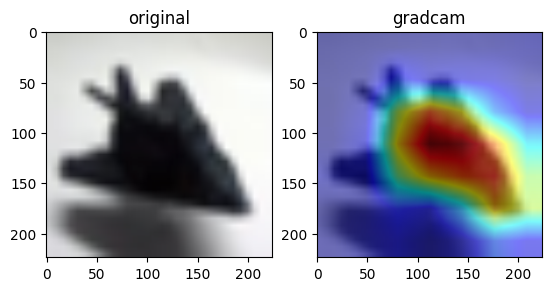

0 0.9999999


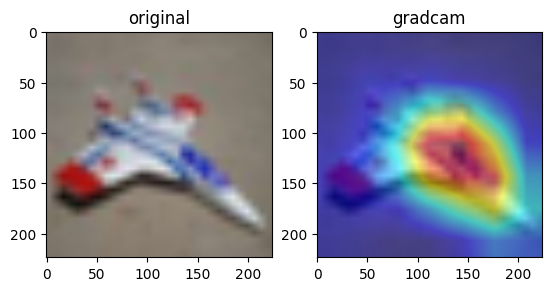

0 0.9999999


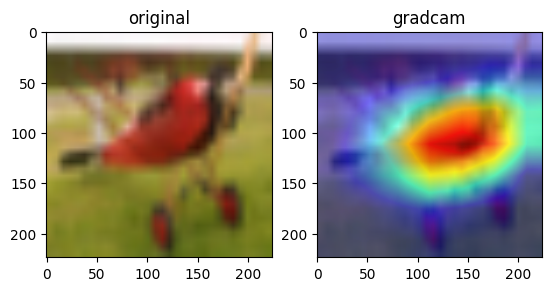

  0%|                                                                   | 37/50000 [00:01<27:48, 29.94it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


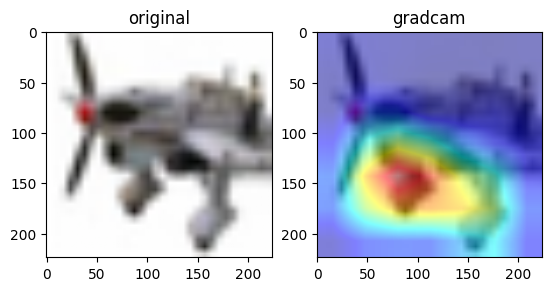

  0%|                                                                   | 77/50000 [00:01<13:03, 63.73it/s]

0 0.9999999


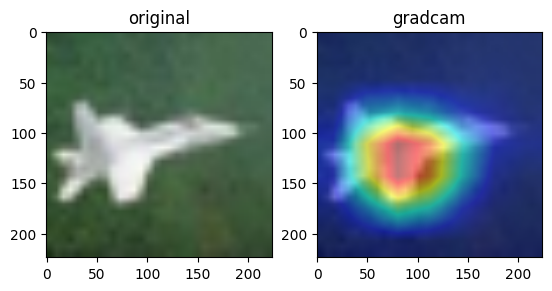

  0%|▏                                                                  | 94/50000 [00:01<17:00, 48.89it/s]


In [11]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from pytorch_grad_cam import GradCAMElementWise


unnorm = UnNormalize(mean,sd)

def visualize_focus(model,test_data,acceptable_labels=[0,1,2,3,4,5,6,7,8,9],max_allowed=5):
  per_label_count = {}
  for label in acceptable_labels:
    per_label_count[label]=0
  target_layers = [model.base[-2][-1]]
  cam = GradCAMElementWise(model=model, target_layers=target_layers, use_cuda=True)
  for input_tensor, label in tqdm(test_data):
    input_tensor=input_tensor.to(DEVICE)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    input_batch=input_tensor.unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_batch, targets=None)
    # if grayscale_cam.max()==0.0 and grayscale_cam.min()==0.0:
    #   continue
    if min(per_label_count.values())>max_allowed:
      break
    elif label not in acceptable_labels:
      continue
    else:
      per_label_count[label]+=1
      if per_label_count[label]>max_allowed:
        continue
    grayscale_cam = grayscale_cam[0, :]

    input_unnorm = unnorm(input_tensor.detach())
    input_numpy = input_unnorm.cpu().numpy()
    input_numpy = np.transpose(input_numpy, (1, 2, 0))
    visualization = show_cam_on_image(input_numpy, grayscale_cam, use_rgb=True)
    print(label, grayscale_cam.max())

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(input_numpy)
    ax1.set_title("original")
    ax2.imshow(visualization)
    ax2.set_title("gradcam")
    plt.show()

visualize_focus(unlearned_model,train_set,acceptable_labels=[0])


In [12]:
unlearned_model

ResNet18_scratch(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [13]:
unlearned_model

ResNet18_scratch(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [14]:
from torchsummary import summary

summary(unlearned_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
test_model=resnet18(pretrained=True).to(DEVICE)
summary(test_model, (3,32,32))

/home/bashlab/env_retry/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bashlab/env_retry/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [16]:
model.layer4[-1]

AttributeError: 'ResNet18_scratch' object has no attribute 'layer4'

In [ ]:
import matplotlib as mpl
from skimage.transform import resize
from matplotlib import pyplot as plt


class GradCamModel(nn.Module):
    def __init__(self,pretrained):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = pretrained
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out


inpimg=train_set[0][0].to(DEVICE).unsqueeze(0)
gcmodel = GradCamModel(unlearned_model).to(DEVICE)
out, acts = gcmodel(inpimg)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([6])).to(DEVICE))
loss.backward()

grads = gcmodel.get_act_grads().detach().cpu()

pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

for i in range(acts.shape[1]):
    acts[:,i,:,:] *= pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max
print(heatmap_j)
heatmap_j = resize(heatmap_j.cpu().numpy(),(32,32),preserve_range=True)
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.2)
fig, axs = plt.subplots(1,1,figsize = (5,5))

unnorm = UnNormalize(mean,sd)
img_unnorm = unnorm(inpimg[0]).cpu().numpy()

axs.imshow(img_unnorm.transpose(1,2,0))
axs.imshow(heatmap_j2)
plt.show()

In [ ]:
print(heatmap_j2)

In [ ]:
summary(torchvision.models.resnet18(pretrained=True).to(DEVICE),(3,128,128))